In [1]:
import math
import h5py
import numpy as np 
import netCDF4 as nc
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

2.1.0a0+29c30b1


In [6]:
#Load the real world SST data
ds3 = xr.open_dataset("real_world_sst.nc", decode_times=False)
ds3

<xarray.Dataset> Size: 33MB
Dimensions:  (time: 74, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 592B 0 365 730 1096 1461 ... 25567 25933 26298 26663
Data variables:
    SST      (time, lat, lon) float64 33MB ...

In [10]:
#Load in real world PRECT data
PRECT_real = pd.read_csv('real_world_prect.csv')
PRECT_real = PRECT_real.set_index(['year', 'region'])
PRECT_real.drop(columns=['Unnamed: 0'], inplace=True)
PRECT_real.head()

,,PRECT
year,region,
1950,North,-1.252478
1951,North,6.405958
1952,North,0.244133
1953,North,-1.394033
1954,North,-9.740346


In [11]:
sst_data = xr.open_dataset('sst.mon.mean.nc', decode_times=True)
sst_data

<xarray.Dataset> Size: 542MB
Dimensions:  (lat: 180, lon: 360, time: 2090)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 17kB 1850-01-01 1850-02-01 ... 2024-02-01
Data variables:
    sst      (time, lat, lon) float32 542MB ...
Attributes:
    title:            created 12/2013 from data provided by JRA
    history:          Created 12/2012 from data obtained from JRA by ESRL/PSD
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pub/ocean/cobe-sst2/
    References:       http://www.psl.noaa.gov/data/gridded/cobe2.html

In [14]:
sst_data['time.month']

<xarray.DataArray 'month' (time: 2090)> Size: 17kB
array([ 1,  2,  3, ..., 12,  1,  2])
Coordinates:
  * time     (time) datetime64[ns] 17kB 1850-01-01 1850-02-01 ... 2024-02-01

In [16]:
#Only include from 1950-2021
mask = (sst_data['time'].dt.year >= 1950) & (sst_data['time'].dt.year <= 2021)
sst_data = sst_data.sel(time=mask)

In [28]:
#Convert to Kelvin
sst_data['sst'] += 273.15

In [35]:
#Calculate nino 3.4 index

def calc_nino(SST_data):
    
    ds = SST_data

    # Select Niño 3.4 region (5N-5S, 170W-120W)
    ds_nino34 = ds.sel(lat=slice(5, -5), lon=slice(190, 240))
    
    # Calculate area-weighted mean SST
    weights = np.cos(np.deg2rad(ds_nino34.lat))
    weights.name = 'weights'
    ds_weighted = ds_nino34['sst'].weighted(weights)
    mean_sst = ds_weighted.mean(dim=['lat', 'lon'])
    ds_nino34 = mean_sst

    # Select Jul-Oct
    month_list = [True if month in [7,8,9,10] else False for month in ds['time.month']]
    ds_nino34 = ds_nino34.loc[{'time' : month_list}] 


    # Calculate temporal mean
    ds_nino34 = ds_nino34.groupby('time.year').mean()
    
    return ds_nino34

nino = calc_nino(sst_data)


In [36]:
nino = nino.to_dataframe()

In [40]:
#Detrend the nino index
from scipy.signal import detrend
nino_notrend = nino.copy()

nino_notrend['sst'] = detrend(nino_notrend['sst'])

nino_notrend.head()

,sst
year,
1950,-0.544189
1951,1.139099
1952,-0.303680
1953,0.776642
1954,-0.630768


In [43]:
#merge with the PRECT data
nino_merge = nino_notrend.reset_index()
prect_merge = PRECT_real.reset_index()
prect_merge[['year']] = prect_merge[['year']].astype(int)
nino_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    72 non-null     int64  
 1   sst     72 non-null     float32
dtypes: float32(1), int64(1)
memory usage: 992.0 bytes


In [54]:
nino_prect = pd.merge(nino_merge, prect_merge, 
         left_on = ['year'], 
         right_on = ['year'],
         validate = 'one_to_many',
         how = 'inner')

nino_prect_train = nino_prect.loc[nino_prect['year'] < 1990]
                                  
nino_prect_test = nino_prect.loc[nino_prect['year'] >= 1990]
nino_prect_train

,year,sst,region,PRECT
0,1950,-0.544189,North,-1.252478
1,1950,-0.544189,Central,-0.238446
2,1950,-0.544189,South,-3.861093
3,1951,1.139099,North,6.405958
4,1951,1.139099,Central,5.686935
...,...,...,...,...
115,1988,-1.522583,Central,-2.564860
116,1988,-1.522583,South,-2.089122
117,1989,-0.388580,North,-10.022521
118,1989,-0.388580,Central,-5.216487


Region: North
Coefficient: [[0.15021618]]
Intercept: [-0.13708602]
R-Squared: 0.00453009573931662
MSE: 47.60144793716522



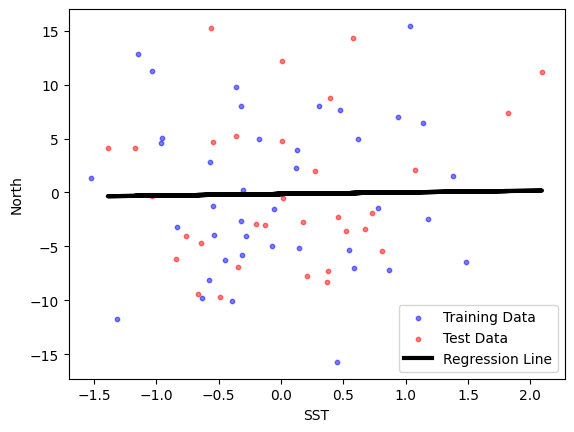

Region: Central
Coefficient: [[1.4393866]]
Intercept: [-0.11917569]
R-Squared: 0.029065941913698268
MSE: 14.55517460903464



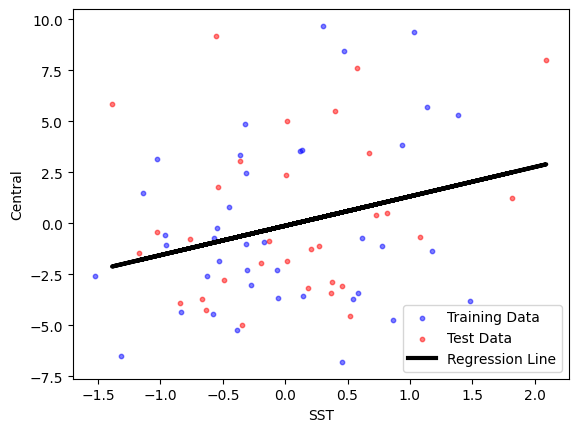

Region: South
Coefficient: [[1.7883308]]
Intercept: [-0.06432688]
R-Squared: 0.10760404827869252
MSE: 12.87453071532762



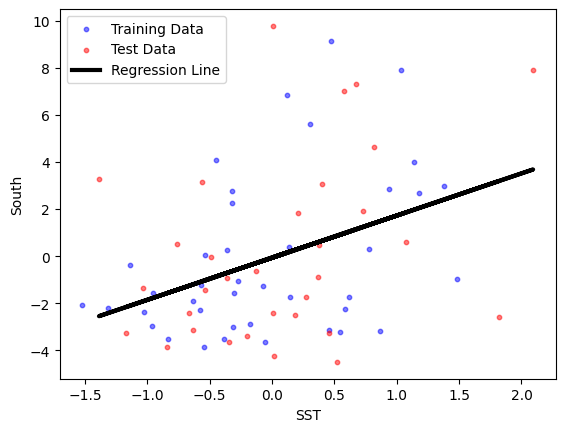

In [59]:
# Train and test linear regression model

from sklearn.metrics import mean_squared_error
for region in nino_prect_test['region'].unique():
    # Train Model
    nino_prect_reg = nino_prect_train.loc[nino_prect_train['region']==region]
    X_train = nino_prect_reg['sst'].values.reshape(-1, 1)
    y_train = nino_prect_reg.PRECT.values.reshape(-1, 1)
    reg = LinearRegression().fit(X_train, y_train)

    # Test Model
    nino_prect_reg_test = nino_prect_test.loc[nino_prect_test['region']==region]
    X_test = nino_prect_reg_test['sst'].values.reshape(-1, 1)
    y_test = nino_prect_reg_test.PRECT.values.reshape(-1, 1)
    predictions = reg.predict(X_test)

    # Print Test Results
    print(f'Region: {region}')
    print(f'Coefficient: {reg.coef_}')
    print(f'Intercept: {reg.intercept_}')
    print(f'R-Squared: {reg.score(X_test, y_test)}')
    print(f'MSE: {mean_squared_error(y_test, predictions)}\n')

    # Plot Train, Test, Regression
    plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.5, s=10)
    plt.scatter(X_test, y_test, color='red', label='Test Data', alpha=0.5, s=10)
    plt.plot(X_test, predictions, color='black', linewidth=3, label='Regression Line')
    plt.xlabel('SST')
    plt.ylabel(region)
    plt.legend()
    plt.show()